<a href="https://colab.research.google.com/github/DONI-13/IMDB-dataset-for-sentiment-analysis-using-NLP/blob/main/NLP_IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
import torch

In [ ]:
# Load the IMDb dataset
data_url = "https://raw.githubusercontent.com/DONI-13/IMDB-dataset-for-sentiment-analysis-using-NLP/main/IMDB%20Dataset.csv"
df = pd.read_csv(data_url)

In [ ]:
# Convert labels to binary
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
from transformers import DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)


In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained DistilBERT with classification head
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Error: You must call wandb.init() before wandb.log()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.22146086394786835,
 'eval_model_preparation_time': 0.0167,
 'eval_runtime': 139.731,
 'eval_samples_per_second': 71.566,
 'eval_steps_per_second': 1.124,
 'epoch': 2.0}

In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
# Example: Show first 5 predictions vs. true labels
predicted_labels = predictions.predictions.argmax(-1)
for i in range(25):
    print(f"Predicted: {predicted_labels[i]}, True: {test_labels[i]}")

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1
Predicted: 0, True: 1


In [ ]:
model.save_pretrained("sentiment-distilbert-imdb")
tokenizer.save_pretrained("sentiment-distilbert-imdb")


('sentiment-distilbert-imdb/tokenizer_config.json',
 'sentiment-distilbert-imdb/special_tokens_map.json',
 'sentiment-distilbert-imdb/vocab.txt',
 'sentiment-distilbert-imdb/added_tokens.json',
 'sentiment-distilbert-imdb/tokenizer.json')

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained("sentiment-distilbert-imdb")
tokenizer = DistilBertTokenizerFast.from_pretrained("sentiment-distilbert-imdb")


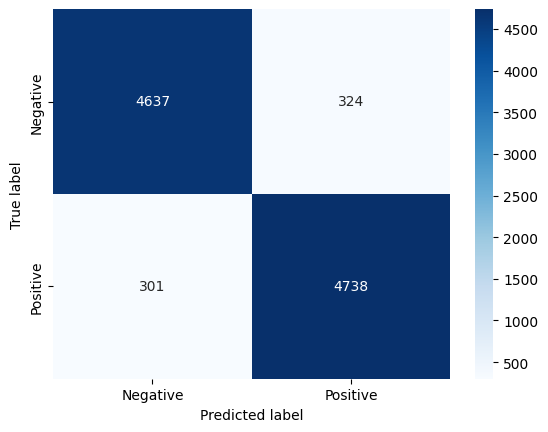

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
!pip install transformers --upgrade --quiet